In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

# set debug = True to see printout's of each step
debug = False

In [2]:
url = "https://www.serebii.net/quest/pokemon.shtml"

# Getting the webpage, creating a Response object.
response = requests.get(url)

# Passing the source code to BeautifulSoup to create a BeautifulSoup object for it.
soup = BeautifulSoup(response.content, 'html.parser')

In [3]:
# get table containing all recipe names and pokemon names/stats
dextable = soup.find_all("table", {"class":"dextable"})[0]

In [4]:
# from dextable, find all pokemon rows?
count = 1
PokemonList = []
for row in dextable.find_all("tr"):
    if( count%2 == 0 ):
        #print(count, row)
        cols = row.find_all("td")
        Pnum = int(cols[0].get_text().strip()[1:])
        Pname = cols[3].get_text().strip()
        if '♂' in Pname:
            Pname = Pname.replace('♂', 'o')
        if '♀' in Pname:
            Pname = Pname.replace('♀', 'a')
        Php = int(cols[6].get_text().strip())
        Patt = int(cols[7].get_text().strip())
        links = cols[8].find_all("a")
        #for c in cols:
        #    print(">>", c.get_text().strip())
        if debug:
            print("*",Pnum,Pname,Php,Patt,Php+Patt,"*")
        PokemonList.append( (Pnum,Pname,Php,Patt,Php+Patt))
    count += 1

In [5]:
# Create .csv file of Pokemon
with open('PokemonQuest.csv', 'w') as f:
    f.write('number,name,hp,attack,total\n')
    for p in PokemonList:
        f.write('%s,%s,%s,%s,%s\n' %(str(p[0]), p[1], str(p[2]),str(p[3]),str(p[4])))

In [6]:
# Now time to strip all of the recipe links from the dextable
links = dextable.find_all("a",{"href":True})
recipelinks = []
for link in links:
    linktext = link['href']
    if( linktext.startswith('/quest') ):
        if linktext not in recipelinks:
            recipelinks.append(linktext)
            if debug:
                print(linktext)

In [7]:
recipeDatabase = []

for link in recipelinks:
    
    # Time to strip the cooking values from each recipe page
    url = "https://www.serebii.net" + link

    # Getting the webpage, creating a Response object.
    response = requests.get(url)

    # Extracting the source code of the page.
    data = response.text

    # Passing the source code to BeautifulSoup to create a BeautifulSoup object for it.
    rsoup = BeautifulSoup(data, 'html.parser')

    rtable = rsoup.find_all("table", {"class":"dextable"})

    # find recipe name
    recipeName = rtable[0].find_all('td', {'class':'fooinfo'})
    recipeName = recipeName[1].get_text().strip()
    if 'à' in recipeName:
        recipeName = recipeName.replace('à', 'a')
    if debug:
        print(recipeName)

    # rtable[2] contains the recipe lists
    tds = rtable[2].find_all("td", {'class':'fooinfo'})
    recipes = []
    for td in tds:
        recipes.append(td.get_text().strip())

    # for each recipe found, search through the following tables and extra info
    recipeIndex = 3
    for recipe in recipes:
        if debug:
            print(">> RECIPE: ", recipe)        
        # recipes are stored in rtable[3] -> rtable[3 + len(recipes) - 1]
        count = 1
        tds = rtable[recipeIndex].find_all("td")
        for t in tds:
            if( (count-3) % 7 == 0 and count > 6):
                #print("Name:", t.get_text().strip())
                Pname = t.get_text().strip()
                if '♂' in Pname:
                    Pname = Pname.replace('♂', 'o')
                if '♀' in Pname:
                    Pname = Pname.replace('♀', 'a')
            if( (count-6) % 7 == 0 and count > 6):
                #print("Rare:", t.get_text().strip()[:-1])
                Prare = t.get_text().strip()[:-1]
                if debug:
                    print("*",recipeName, recipe,Pname, Prare)
                recipeDatabase.append( (recipeName,recipe,Pname,Prare) )
            count += 1
        recipeIndex += 1

In [8]:
# create a CSV file out of the recipeDatabase
# each row has format: (recipeName,recipe,Pname,Prare)
with open('PokemonQuestRecipe.csv', 'w') as f:
    f.write('recipe,ingredients,name,rarity\n')
    for row in recipeDatabase:
        f.write(row[0] + "," + row[1] + "," + row[2] + "," + row[3] + "\n")

In [9]:
df = pd.read_csv('PokemonQuest.csv')
df1 = pd.read_csv('PokemonQuestRecipe.csv')

In [10]:
searchName = "Horsea"
df[df['name'] == searchName]

,number,name,hp,attack,total
115,116,Horsea,90,110,200


In [11]:
# Sort recipies for above Pokemon by rarity
df1[df1['name'] == searchName].sort_values(by=['rarity'],ascending=False)

,recipe,ingredients,name,rarity
303,Mouth-Watering Dip a la Cube,3 Bluk Berry1 Apricorn1 Honey,Horsea,24.52
267,Blue Soda a la Cube,1 Icy Rock3 or more Bluk Berry,Horsea,19.71
312,Mouth-Watering Dip a la Cube,1 Icy Rock2 Bluk Berry2 Honey,Horsea,18.02
279,Blue Soda a la Cube,2 Icy Rock2 or more Bluk Berry,Horsea,15.41
42,Mulligan Stew a la Cube,Any 4 Normal & 1 Precious,Horsea,4.65
104,Mulligan Stew a la Cube,Any 3 Normal & 2 Precious,Horsea,2.00


In [12]:
# top 5 by hp
df.sort_values(by=['hp'],ascending=False).head(5)

,number,name,hp,attack,total
75,76,Golem,700,100,800
112,113,Chansey,675,25,700
79,80,Slowbro,650,150,800
142,143,Snorlax,650,150,800
130,131,Lapras,650,150,800


In [13]:
# top 5 by att
df.sort_values(by=['attack'],ascending=False).head(5)

,number,name,hp,attack,total
149,150,Mewtwo,550,750,1300
126,127,Pinsir,75,725,800
64,65,Alakazam,100,700,800
122,123,Scyther,100,700,800
141,142,Aerodactyl,125,675,800


In [14]:
# top 5 by total strength
df[df['total'] >= 800].sort_values(by=['total'],ascending=False).head(5)

,number,name,hp,attack,total
150,151,Mew,650,650,1300
149,150,Mewtwo,550,750,1300
145,146,Moltres,500,500,1000
144,145,Zapdos,350,650,1000
143,144,Articuno,600,400,1000


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

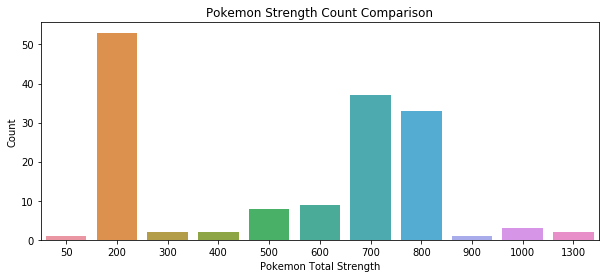

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4)

ax = sns.countplot(x="total",data=df)
ax.set(xlabel='Pokemon Total Strength', ylabel='Count', title="Pokemon Strength Count Comparison");